In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import joblib
from fastapi import FastAPI
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
import xgboost as xgb_lib
import matplotlib.pyplot as plt
import shap, json
import warnings


In [33]:
accepted_path = "C:/Users/esteb/PythonProjects/Portfolio/ml_project/data/raw/accepted_2007_to_2018Q4.csv"


In [34]:
print("Loading accepted loans...")
df = pd.read_csv(accepted_path, low_memory=False)
print(f"Accepted loans shape: {df.shape}")

Loading accepted loans...
Accepted loans shape: (2260701, 151)


## Exploratory Data Analysis, Data Cleaning, Feature Engineering, and Variable Selection.

In [35]:
# Initialize tracking for dropped columns and reasons
dropped_columns_log = pd.DataFrame(columns=["Column", "Reason"])
drop_tracker = {'columns_dropped': []}

def drop_and_log(df, cols, reason):
    """Drop columns from df and log why they were dropped."""
    global dropped_columns_log
    cols_to_drop = [c for c in cols if c in df.columns]
    if cols_to_drop:
        dropped_columns_log = pd.concat([
            dropped_columns_log,
            pd.DataFrame({"Column": cols_to_drop, "Reason": reason})
        ], ignore_index=True)
    return df.drop(columns=cols_to_drop, errors='ignore')

In [36]:
# -----------------Handling NAs / Missing Data--------------------
def clean_missing_data_simple(df, drop_thresh=0.25):
    global dropped_columns_log
    missing_summary = (pd.DataFrame(df.isna().sum(), columns=['mis_count'])
                       .assign(Missing_Percentage=lambda x: x['mis_count']/df.shape[0]*100)
                       .sort_values('mis_count', ascending=False)
                       .reset_index()
                       .rename(columns={'index': 'Column'}))
    
    drop_cols = missing_summary[missing_summary['Missing_Percentage'] >= (drop_thresh*100)]['Column'].tolist()
    df_clean = drop_and_log(df, drop_cols, f"Missing ≥ {drop_thresh*100:.0f}%")
    
    # Impute missing values
    num_cols = df_clean.select_dtypes(include='number').columns
    cat_cols = df_clean.select_dtypes(include='object').columns
    
    for col in num_cols:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    for col in cat_cols:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
        
    return df_clean, missing_summary

# Apply missing data cleaning
df_clean, missing_summary = clean_missing_data_simple(df, drop_thresh=0.25)


In [37]:
# ----------------- CATEGORICAL CLEANING + TRACKING -----------------
warnings.filterwarnings('ignore', category=FutureWarning)

# 1) Drop clearly unhelpful, internal, or leaky columns
df_clean = drop_and_log(df_clean, [
    'id', 'url', 'zip_code', 'title', 'sub_grade',  # overly granular/unhelpful
    'addr_state', 'emp_title', 'last_pymnt_d',      # personal/internal info
    'grade',                                        # Lending Club internal metric
    'pymnt_plan',                                   # only known after origination
    'initial_list_status',                          # internal listing info (leakage)
    'hardship_flag',                                # reflects prior hardship (leakage)
    'disbursement_method',                          # internal disbursement info
    'debt_settlement_flag'                          # prior settlements (leakage)
], reason="Internal/Leaky/Unhelpful categorical field")

# 2) Transform categorical columns

## a) EMP_LENGTH — bucketed
if 'emp_length' in df_clean.columns:
    df_clean['emp_length'] = (
        df_clean['emp_length'].str.lower().str.strip()
        .replace({
            '< 1 year': '0', '1 year': '1', '2 years': '2', '3 years': '3',
            '4 years': '4', '5 years': '5', '6 years': '6', '7 years': '7',
            '8 years': '8', '9 years': '9', '10+ years': '10', 'n/a': np.nan
        }).astype(float)
    )
    df_clean['emp_length'] = pd.cut(
        df_clean['emp_length'],
        bins=[-1, 3, 7, 9, float('inf')],
        labels=['0–3 years', '4–7 years', '8–9 years', '10+ years']
    )

## b) HOME_OWNERSHIP — combine similar categories
if 'home_ownership' in df_clean.columns:
    df_clean['home_ownership'] = (
        df_clean['home_ownership'].str.upper().str.strip()
        .replace({
            'MORTGAGE': 'OWN_HOME', 'OWN': 'OWN_HOME', 'RENT': 'RENT',
            'ANY': 'OTHER', 'NONE': 'OTHER', 'OTHER': 'OTHER'
        })
    )

## c) PURPOSE — broader categories
if 'purpose' in df_clean.columns:
    df_clean['purpose'] = (
        df_clean['purpose'].str.lower().str.strip()
        .replace({
            'debt_consolidation': 'debt_consolidation',
            'credit_card': 'debt_consolidation',
            'small_business': 'business',
            'home_improvement': 'home',
            'house': 'home',
            'major_purchase': 'personal',
            'car': 'auto',
            'wedding': 'personal',
            'vacation': 'personal',
            'moving': 'personal',
            'medical': 'other',
            'educational': 'other',
            'renewable_energy': 'home',
            'other': 'other'
        })
    )

## d) VERIFICATION_STATUS — simplify categories
if 'verification_status' in df_clean.columns:
    df_clean['verification_status'] = (
        df_clean['verification_status'].str.strip()
        .replace({
            'Not Verified': 'Not Verified',
            'Source Verified': 'Verified',  # merge into Verified
            'Verified': 'Verified'
        })
    )

## e) DATE FIELDS — bucket into eras

# Earliest Credit Line
if 'earliest_cr_line' in df_clean.columns:
    df_clean['earliest_cr_line'] = pd.to_datetime(
        df_clean['earliest_cr_line'], format='%b-%Y', errors='coerce'
    )
    earliest_bins = [
        pd.Timestamp('1930-01-01'),
        pd.Timestamp('1970-12-31'),
        pd.Timestamp('1989-12-31'),
        pd.Timestamp('1999-12-31'),
        pd.Timestamp('2009-12-31'),
        pd.Timestamp('2015-12-31')
    ]
    earliest_labels = ['1930–1970', '1971–1989', '1990–1999', '2000–2009', '2010–2015']
    df_clean['earliest_cr_line'] = pd.cut(
        df_clean['earliest_cr_line'], bins=earliest_bins, labels=earliest_labels
    )

# Issue Date
if 'issue_d' in df_clean.columns:
    df_clean['issue_d'] = pd.to_datetime(df_clean['issue_d'], format='%b-%Y', errors='coerce')
    issue_bins = [
        pd.Timestamp('2007-01-01'),
        pd.Timestamp('2010-12-31'),
        pd.Timestamp('2013-12-31'),
        pd.Timestamp('2016-12-31'),
        pd.Timestamp('2018-12-31')
    ]
    issue_labels = ['2007–2010', '2011–2013', '2014–2016', '2017–2018']
    df_clean['issue_d'] = pd.cut(df_clean['issue_d'], bins=issue_bins, labels=issue_labels)

# Last Credit Pull
if 'last_credit_pull_d' in df_clean.columns:
    df_clean['last_credit_pull_d'] = pd.to_datetime(
        df_clean['last_credit_pull_d'], format='%b-%Y', errors='coerce'
    )
    pull_bins = [
        pd.Timestamp('2007-01-01'),
        pd.Timestamp('2010-12-31'),
        pd.Timestamp('2013-12-31'),
        pd.Timestamp('2016-12-31'),
        pd.Timestamp('2018-12-31'),
        pd.Timestamp('2019-12-31')
    ]
    pull_labels = ['2007–2010', '2011–2013', '2014–2016', '2017–2018', '2019']
    df_clean['last_credit_pull_d'] = pd.cut(
        df_clean['last_credit_pull_d'], bins=pull_bins, labels=pull_labels
    )

# 3) TARGET VARIABLE — overwrite loan_status with 0/1
if 'loan_status' in df_clean.columns:
    df_clean['loan_status'] = (
        df_clean['loan_status']
        .str.replace(r'Does not meet the credit policy. Status:', '', regex=True)
        .str.strip()
        .replace({
            'Fully Paid': 0,
            'Current': 0,
            'In Grace Period': 0,
            'Late (16-30 days)': 1,
            'Late (31-120 days)': 1,
            'Charged Off': 1,
            'Default': 1
        })
        .astype(float)
    )

# 4) Convert selected object columns to category for modeling
for col in ['term', 'home_ownership', 'purpose', 'application_type', 'verification_status']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype('category')

# 5) Display categorical columns and target counts
df_clean_cat = df_clean.select_dtypes(include=['object', 'category']).copy()
for col in df_clean_cat.columns:
    unique_vals = df_clean_cat[col].dropna().unique()
    print(f"--- {col} --- {unique_vals}")
    print(f"Unique count: {len(unique_vals)}\n")

print("\nloan_status value counts:")
print(df_clean['loan_status'].value_counts(dropna=False))


--- term --- [' 36 months', ' 60 months']
Categories (2, object): [' 36 months', ' 60 months']
Unique count: 2

--- emp_length --- ['10+ years', '0–3 years', '4–7 years', '8–9 years']
Categories (4, object): ['0–3 years' < '4–7 years' < '8–9 years' < '10+ years']
Unique count: 4

--- home_ownership --- ['OWN_HOME', 'RENT', 'OTHER']
Categories (3, object): ['OTHER', 'OWN_HOME', 'RENT']
Unique count: 3

--- verification_status --- ['Not Verified', 'Verified']
Categories (2, object): ['Not Verified', 'Verified']
Unique count: 2

--- issue_d --- ['2014–2016', '2017–2018', '2011–2013', '2007–2010']
Categories (4, object): ['2007–2010' < '2011–2013' < '2014–2016' < '2017–2018']
Unique count: 4

--- purpose --- ['debt_consolidation', 'business', 'home', 'personal', 'other', 'auto']
Categories (6, object): ['auto', 'business', 'debt_consolidation', 'home', 'other', 'personal']
Unique count: 6

--- earliest_cr_line --- ['2000–2009', '1990–1999', '1971–1989', '2010–2015', '1930–1970']
Categories

In [38]:
# Create average FICO
df_clean['last_fico_avg'] = (df_clean['last_fico_range_low'] + df_clean['last_fico_range_high']) / 2

# Drop the original range columns
df_clean = df_clean.drop(columns=['last_fico_range_low', 'last_fico_range_high', 'fico_range_low', 'fico_range_high'])

In [39]:
#----------------Dropping / Cleaning Numeric Columns-----------------
def drop_low_variance_columns(df, threshold=0.95, log_df=None):
    """
    Drops columns where the most frequent value appears in >= threshold proportion of rows.
    
    Parameters:
        df (pd.DataFrame): Input dataframe.
        threshold (float): Proportion threshold for dropping (default=0.95).
        log_df (pd.DataFrame): Optional existing log to append to.
    
    Returns:
        df_clean (pd.DataFrame): DataFrame with low-variance columns dropped.
        variance_log (pd.DataFrame): DataFrame listing dropped columns and their top frequency.
    """
    low_variance_cols = []
    for col in df.columns:
        try:
            top_freq = df[col].value_counts(normalize=True, dropna=False).iloc[0]
            if top_freq >= threshold:
                low_variance_cols.append((col, round(top_freq, 3)))
        except Exception:
            pass  # skip if value_counts fails on mixed types
    
    variance_log = pd.DataFrame(low_variance_cols, columns=["Column", "Top Frequency"])
    variance_log["Reason"] = f"Low variance ≥ {threshold*100:.0f}%"

    df_clean = df.drop(columns=variance_log["Column"], errors="ignore")

    # Append to existing log (if provided)
    if log_df is not None:
        log_df = pd.concat([log_df, variance_log], ignore_index=True)
        return df_clean, log_df
    else:
        return df_clean, variance_log

# Apply low-variance drop
df_clean, dropped_columns_log = drop_low_variance_columns(df_clean, threshold=0.95, log_df=dropped_columns_log)

# Print only the low-variance drops
print("Columns dropped due to low variance:")
print(dropped_columns_log[dropped_columns_log['Reason'].str.contains("Low variance")])


Columns dropped due to low variance:
                        Column              Reason  Top Frequency
72          total_rec_late_fee  Low variance ≥ 95%          0.961
73  collections_12_mths_ex_med  Low variance ≥ 95%          0.983
74                 policy_code  Low variance ≥ 95%          1.000
75              acc_now_delinq  Low variance ≥ 95%          0.996
76    chargeoff_within_12_mths  Low variance ≥ 95%          0.992
77                 delinq_amnt  Low variance ≥ 95%          0.997
78            num_tl_120dpd_2m  Low variance ≥ 95%          0.999
79                num_tl_30dpd  Low variance ≥ 95%          0.997
80                   tax_liens  Low variance ≥ 95%          0.971


Low-variance columns can have prediction capabilities in default models but these
Columns dropped are either data leakage variables
(variables that would only be known after funding the loan),
metadata, or they are measured in the FICO score so they would cause multicollinearity.


In [40]:
#--- Remove redundant or highly correlated features ---
# Ensure dropped_columns_log exists
if 'dropped_columns_log' not in globals():
    dropped_columns_log = pd.DataFrame(columns=["Column", "Reason"])

# Prepare X and y
if 'X' not in globals() or 'y' not in globals(): 
    target_col = 'loan_status'
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]

# Separate numeric and categorical
numeric_cols = [c for c in X.columns if is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if not is_numeric_dtype(X[c])]
numeric_X = X[numeric_cols].copy()

# Compute correlation matrix and upper triangle
corr_matrix = numeric_X.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify highly correlated features
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

# Drop and log
if to_drop:
    X = drop_and_log(X, to_drop, reason="High correlation (>0.9)")

print(f"Remaining columns after correlation filtering: {X.shape[1]}")

# Optional: show what was dropped
if to_drop:
    print("\nColumns dropped due to high correlation:")
    print(dropped_columns_log[dropped_columns_log['Reason'].str.contains("High correlation")])


Remaining columns after correlation filtering: 13


In [41]:
# --- Filter strong numeric features using ANOVA F-test ---
from sklearn.feature_selection import f_classif

numeric_X = X.select_dtypes(include=np.number)

# Minimum required features
required_features = ['loan_amnt', 'last_fico_avg', 'annual_inc']
required_features = [f for f in required_features if f in numeric_X.columns]

# Compute ANOVA F-scores
f_scores, p_values = f_classif(numeric_X, y)
f_score_df = pd.DataFrame({'feature': numeric_X.columns, 'f_score': f_scores})

# Set a threshold for "strong predictors"
f_threshold = 5  # adjust as needed based on your data
strong_features = f_score_df[f_score_df['f_score'] >= f_threshold]['feature'].tolist()

# Ensure required features are included
for f in required_features:
    if f not in strong_features:
        strong_features.append(f)

# Identify dropped features
dropped_numeric = set(numeric_X.columns) - set(strong_features)

# Drop weak features and log
if dropped_numeric:
    X = drop_and_log(X, list(dropped_numeric), reason="Low ANOVA F-score")

# Update numeric_X
numeric_X = X[strong_features]

print(f"Remaining numeric columns after ANOVA filtering: {numeric_X.shape[1]}")
print("\nColumns dropped due to low ANOVA F-score:")
mask = dropped_columns_log['Reason'].str.contains("ANOVA", case=False, na=False)
print(dropped_columns_log[mask])


Remaining numeric columns after ANOVA filtering: 4

Columns dropped due to low ANOVA F-score:
Empty DataFrame
Columns: [Column, Reason, Top Frequency]
Index: []


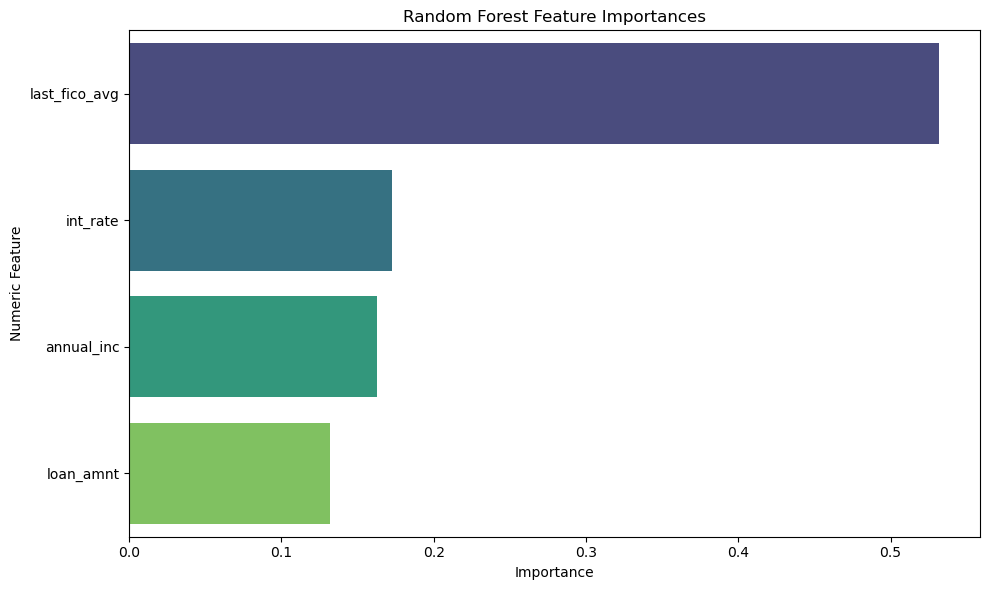

In [42]:
# --- Random Forest feature importances ---
# Set a random seed for reproducibility
sample_frac = 0.2
numeric_X_sampled = numeric_X.sample(frac=sample_frac, random_state=42)
y_sampled = y.loc[numeric_X_sampled.index] 

# Fit Random Forest on sampled data
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(numeric_X_sampled, y_sampled)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=numeric_X.columns).sort_values(ascending=False)

# --- Plot feature importances ---
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Numeric Feature")
plt.tight_layout()
plt.show()

In [43]:
# --- Drop low-importance numeric features ---
top_features = importances[importances > 0.01].index.tolist()  # or pick top N
low_importance_cols = set(numeric_X.columns) - set(top_features)

if low_importance_cols:
    X = drop_and_log(X, list(low_importance_cols), reason="Low importance (Random Forest)")

# Update numeric_X
numeric_X = X[top_features]

print("Remaining numeric features after Random Forest filtering:")
print(top_features)

Remaining numeric features after Random Forest filtering:
['last_fico_avg', 'int_rate', 'annual_inc', 'loan_amnt']


In [44]:
# Identify leaky or post-loan variables to drop
leakage_cols = [
    'recoveries', 'last_pymnt_amnt', 'out_prncp',
    'total_pymnt', 'total_rec_int'
]

# Drop and log reason
X = drop_and_log(X, leakage_cols, reason="Post-loan or leakage feature")

# Update numeric_X after dropping
numeric_X = X.select_dtypes(include=np.number)

print("Remaining numeric features after removing leakage variables:")
print(list(numeric_X.columns))


Remaining numeric features after removing leakage variables:
['loan_amnt', 'int_rate', 'last_fico_avg', 'annual_inc']


In [45]:
# Ensure annual_inc is included in numeric features
if 'annual_inc' in df_clean.columns and 'annual_inc' not in X.columns:
    X['annual_inc'] = df_clean['annual_inc']

# Update numeric_X to include it again
numeric_X = X.select_dtypes(include=np.number)

print("Final numeric features after re-adding annual_inc:")
print(list(numeric_X.columns))

Final numeric features after re-adding annual_inc:
['loan_amnt', 'int_rate', 'last_fico_avg', 'annual_inc']


In [46]:
#### Final dataset after cleaning.

In [47]:
# --- Combine final numeric + categorical features into df_final ---

# Ensure we have categorical and numeric subsets
categorical_X = X.select_dtypes(exclude=[np.number]).copy()

# Ensure target column is defined
target_col = 'loan_status'

# Combine numeric and categorical data
df_final = pd.concat([numeric_X, categorical_X], axis=1)

# Add target variable back
df_final[target_col] = y.values

# Summary of final dataset
print("\n Final dataset summary:")
print(f"- Numeric features kept: {numeric_X.shape[1]}")
print(f"- Categorical features kept: {categorical_X.shape[1]}")
print(f"- Total features (excluding target): {df_final.shape[1] - 1}")
print(f"- Total rows: {df_final.shape[0]}")

# Optional: show the first few columns for confirmation
print("\nColumns in final dataset:")
print(df_final.columns.tolist())



 Final dataset summary:
- Numeric features kept: 4
- Categorical features kept: 9
- Total features (excluding target): 13
- Total rows: 2260701

Columns in final dataset:
['loan_amnt', 'int_rate', 'last_fico_avg', 'annual_inc', 'term', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'earliest_cr_line', 'last_credit_pull_d', 'application_type', 'loan_status']


## Modeling

In [48]:
# --- Random Forest ---

# --- Setup ---
target_col = 'loan_status'
y = df_final[target_col]
X = df_final.drop(columns=[target_col])

# --- 1. Sample for performance ---
sample_frac = 0.1  # adjust to 0.05 if still slow
X_sample, _, y_sample, _ = train_test_split(
    X, y,
    train_size=sample_frac,
    stratify=y,
    random_state=42
)

# --- 2. Encode categorical variables ---
categorical_cols = X_sample.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_sample.select_dtypes(include=[np.number]).columns.tolist()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
if categorical_cols:
    X_cat_encoded = pd.DataFrame(
        encoder.fit_transform(X_sample[categorical_cols]),
        columns=categorical_cols,
        index=X_sample.index
    )
    X_model = pd.concat([X_sample[numeric_cols], X_cat_encoded], axis=1)
else:
    X_model = X_sample[numeric_cols]

# --- 3. Cross-validation setup ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 4. Random Forest baseline ---
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(rf, X_model, y_sample, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Random Forest Cross-validated ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

# --- 5. Train/test split for metrics ---
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y_sample,
    test_size=0.2,
    stratify=y_sample,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Random Forest Cross-validated ROC AUC: 0.9393 ± 0.0020

Random Forest Performance:
Accuracy: 0.9238067855089132
ROC AUC: 0.9407644955599264

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96     39310
         1.0       0.80      0.55      0.65      5904

    accuracy                           0.92     45214
   macro avg       0.87      0.77      0.81     45214
weighted avg       0.92      0.92      0.92     45214



In [49]:
warnings.filterwarnings('ignore', category=FutureWarning)

# --- XGBoost model (SHAP-compatible) ---
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

# Cross-validation
xgb_scores = cross_val_score(xgb, X_model, y_sample, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"\nXGBoost Cross-validated ROC AUC: {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")

# Train/test split metrics
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("\nXGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


XGBoost Cross-validated ROC AUC: 0.9541 ± 0.0012


C:\Users\esteb\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:52:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Performance:
Accuracy: 0.933250763037997
ROC AUC: 0.9567674175771904

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     39310
         1.0       0.77      0.69      0.73      5904

    accuracy                           0.93     45214
   macro avg       0.86      0.83      0.85     45214
weighted avg       0.93      0.93      0.93     45214



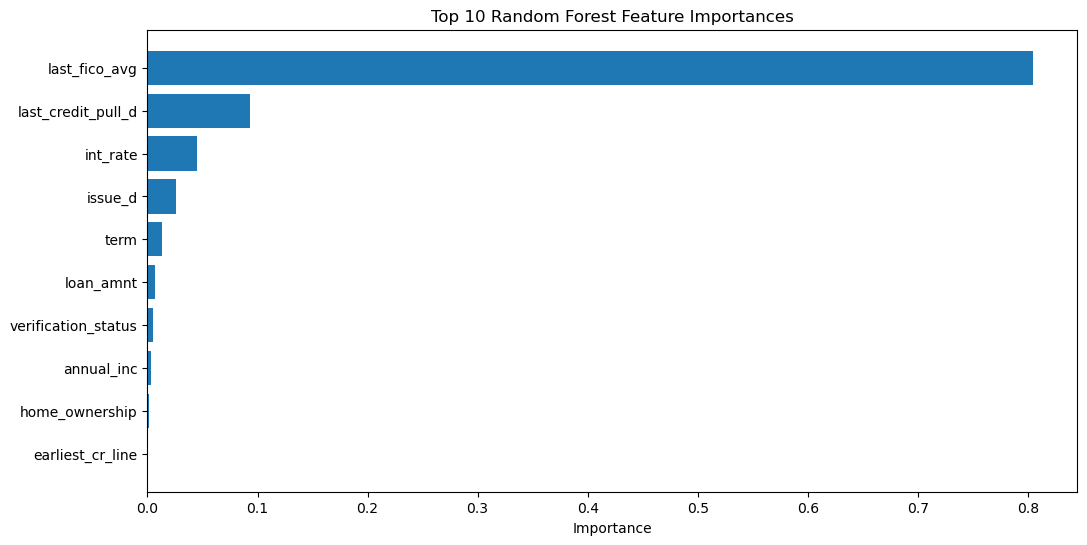

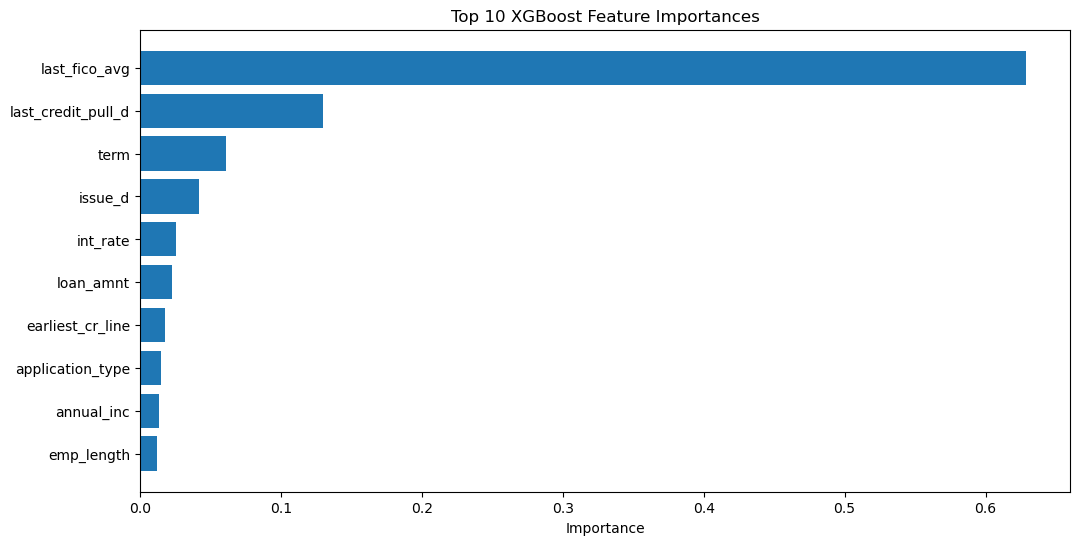

In [50]:
# --- Feature importance visualization ---
rf_importances = pd.Series(rf.feature_importances_, index=X_model.columns).sort_values(ascending=False)
xgb_importances = pd.Series(xgb.feature_importances_, index=X_model.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(rf_importances.head(10).index[::-1], rf_importances.head(10).values[::-1])
plt.title("Top 10 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(xgb_importances.head(10).index[::-1], xgb_importances.head(10).values[::-1])
plt.title("Top 10 XGBoost Feature Importances")
plt.xlabel("Importance")
plt.show()

In [51]:
warnings.filterwarnings('ignore', category=FutureWarning)

# --- XgBoost Hyper Parameter Tuning ---
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

xgb_base = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,  # number of random combinations
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on your sampled training data
random_search.fit(X_train, y_train)

best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("Best hyperparameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\esteb\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:53:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best hyperparameters: {'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}
Accuracy: 0.9337152209492635
ROC AUC: 0.9570721340481021

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     39310
         1.0       0.78      0.69      0.73      5904

    accuracy                           0.93     45214
   macro avg       0.87      0.83      0.85     45214
weighted avg       0.93      0.93      0.93     45214



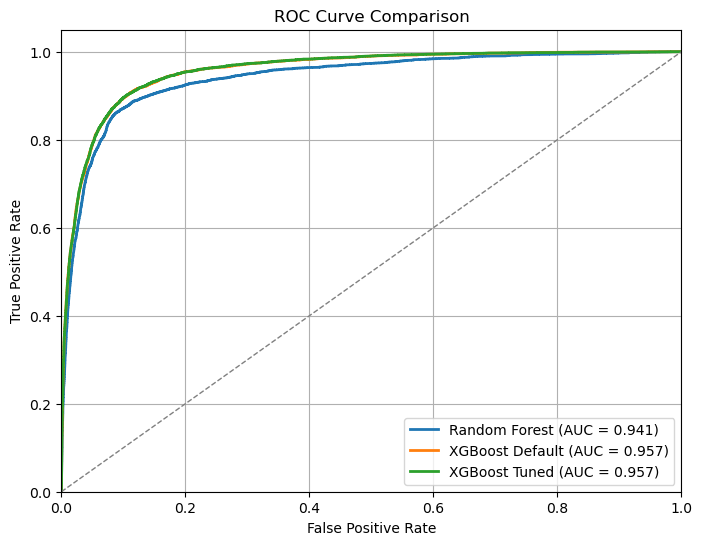

In [52]:

# --- Compute ROC curves ---
models = {
    "Random Forest": rf,
    "XGBoost Default": xgb,
    "XGBoost Tuned": best_xgb
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# --- Plot formatting ---
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Deployment

In [54]:
# --- Model folder ---
model_folder = "C:/Users/esteb/PythonProjects/Portfolio/ml_project/models"
os.makedirs(model_folder, exist_ok=True)

# --- Categorical and Numeric Columns ---
categorical_cols = [
    'term', 'emp_length', 'home_ownership', 'verification_status',
    'issue_d', 'purpose', 'earliest_cr_line', 'last_credit_pull_d',
    'application_type'
]

numeric_cols = ['loan_amnt', 'int_rate', 'last_fico_avg', 'annual_inc']

# --- Make sure the dtypes are correct ---
X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_train[numeric_cols] = X_train[numeric_cols].apply(pd.to_numeric, errors='coerce')

# --- OrdinalEncoder with exact categories from training data ---
encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    categories=[
        [' 36 months', ' 60 months'],  # term, keep leading space
        ['0–3 years', '4–7 years', '8–9 years', '10+ years'],  # emp_length
        ['OTHER', 'OWN_HOME', 'RENT'],  # home_ownership
        ['Not Verified', 'Verified'],  # verification_status
        ['2007–2010', '2011–2013', '2014–2016', '2017–2018'],  # issue_d
        ['debt_consolidation', 'business', 'home', 'personal', 'other', 'auto'],  # purpose
        ['1930–1970', '1971–1989', '1990–1999', '2000–2009', '2010–2015'],  # earliest_cr_line
        ['2007–2010', '2011–2013', '2014–2016', '2017–2018', '2019'],  # last_credit_pull_d
        ['Individual', 'Joint App']  # application_type
    ]
)

# --- ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# --- Pipeline ---
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])

# --- Fit pipeline on training data ---
model_pipeline.fit(X_train, y_train)

# --- Save full pipeline ---
#pipeline_path = os.path.join(model_folder, "loan_model_pipeline.pkl")
#joblib.dump(model_pipeline, pipeline_path)
#print(f"Pipeline saved to: {pipeline_path}")

# --- Save compressed version ---
compressed_path = os.path.join(model_folder, "loan_model_pipeline_compressed.pkl")
joblib.dump(model_pipeline, compressed_path, compress=3)
print(f"Compressed pipeline saved to: {compressed_path}")


Pipeline saved to: C:/Users/esteb/PythonProjects/Portfolio/ml_project/models\loan_model_pipeline.pkl
Compressed pipeline saved to: C:/Users/esteb/PythonProjects/Portfolio/ml_project/models\loan_model_pipeline_compressed.pkl
